## Deep Learning to get Steering Angle: Behaviour Cloning Project

### Overview of the the project

In this project the objective is to develop a deep learning algorithm in keras to mimic human driving behaviour. Data is collected by udacity for track 1 using the simulator. I generated my own data but did not use it for the project as the steering angle was very jerky because of controlling the car using keyborad. 8036*3 images were generated in the udacity data for left, center and right cameras. I used the image augmentation techiques to generate random data to represent driving under different driving conditions. Model was run for 30 iterations. Validation loss is calculated to see the performance of the model but validation data's performance did not transfer to model performance on the track. That is the reason there is no check on the validation to stop training, instead it only helps to find out the best model according to validation loss among all the models saved at each iteration. Driving on the track 1 is considered to be the ultimate validation test for the model. The top 5 models are tested to find out the model which will successfully drive through tthe track for atleast one lap. The selected model selected for submission is good enough to drive through tthe track 1 for as many laps as possible. This notebook includes basic data exploration, data augmentation, Nvidia's Model architecture used and Training Details.

In [1]:
import os
import pandas as pd
import numpy as np
from scipy import signal
import cv2
import math
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import random


tf.python.control_flow_ops = tf

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation,Lambda
from keras.layers import Input, ELU
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils
from keras.layers import Convolution2D, MaxPooling2D, Flatten
from keras import initializations

from pathlib import Path
import json

Using TensorFlow backend.


## Loading Data

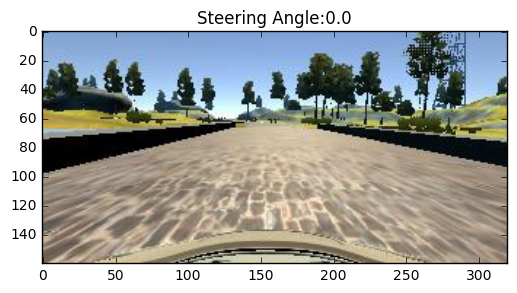

In [2]:
path = 'data/data/'
csv_path = 'data/data/driving_log.csv'
df = pd.read_csv(csv_path, index_col = False)

image = plt.imread(path+df['center'][0].strip())
angle = df['steering'][0]
plt.title("Steering Angle:"+str(angle))
plt.imshow(image)

## Data Exploration
Images from left, center and right cameras are there beside the steering angle, throttle, brake and speed information. Total 8036 frames are there. It is intresting to know that the 75th percentile of the data contains the steering angle=0 which is also evident from the plotting of steering angle values. 

In [3]:
df.columns.values.tolist()

['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed']

In [4]:
len(df)

8036

In [5]:
df.describe()

,steering,throttle,brake,speed
count,8036.000000,8036.000000,8036.000000,8036.000000
mean,0.004070,0.869660,0.001970,28.169839
std,0.128840,0.301326,0.036565,6.149327
min,-0.942695,0.000000,0.000000,0.502490
25%,0.000000,0.985533,0.000000,30.183093
50%,0.000000,0.985533,0.000000,30.186400
75%,0.000000,0.985533,0.000000,30.186640
max,1.000000,0.985533,1.000000,30.709360


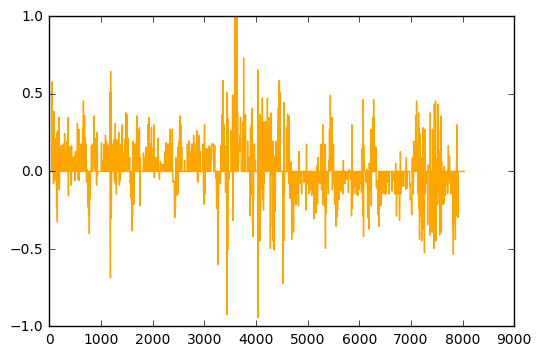

In [6]:
plt.plot(df.steering,color='orange')

## Changing Image Brightness

Change in image brightness to generate additional data will help us to generalize to different lighting conditions. RGB image is converted to HSV and V channel is scaled to change the brightness and then image is converted back to RGB. 

In [7]:
def change_brightness(image,brightness_range):
    hsv = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = brightness_range+np.random.uniform()
    hsv[:,:,2] = hsv[:,:,2]*random_bright
    rgb = cv2.cvtColor(hsv,cv2.COLOR_HSV2RGB)
    return rgb

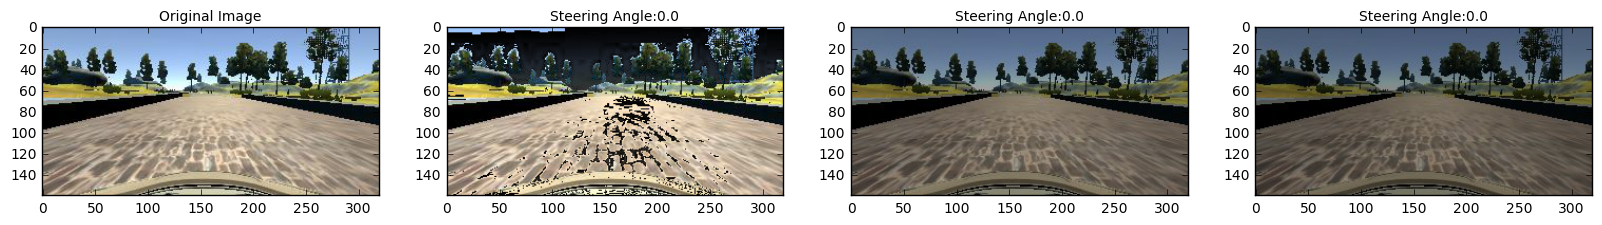

In [8]:
f, (ax1, ax2,ax3,ax4 ) = plt.subplots(1, 4, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=10)

ax2.imshow(change_brightness(image,0.25))
ax2.set_title("Steering Angle:"+str(angle), fontsize=10)

ax3.imshow(change_brightness(image,0.25))
ax3.set_title("Steering Angle:"+str(angle), fontsize=10)


ax4.imshow(change_brightness(image,0.25))
ax4.set_title("Steering Angle:"+str(angle), fontsize=10)


## Image Rotation and New Angle

Shifting the camera images to right or left helps in generating the data for simulating car at different positions in the lane. Random shifts were applied in horizontal directoins anad steering angle is adjusted accordingly.  

In [9]:
def image_translation(image, angle, x_translation_range, y_translation_range, angle_translation_range):
    x_translation = (x_translation_range * np.random.uniform()) - (x_translation_range / 2)
    new_angle = angle + ((x_translation / x_translation_range) * 2) * angle_translation_range
    y_translation = (y_translation_range * np.random.uniform()) - (y_translation_range / 2)
    translation_matrix = np.float32([[1, 0, x_translation], [0, 1, y_translation]])

    return cv2.warpAffine(image, translation_matrix, (image.shape[1], image.shape[0])),new_angle

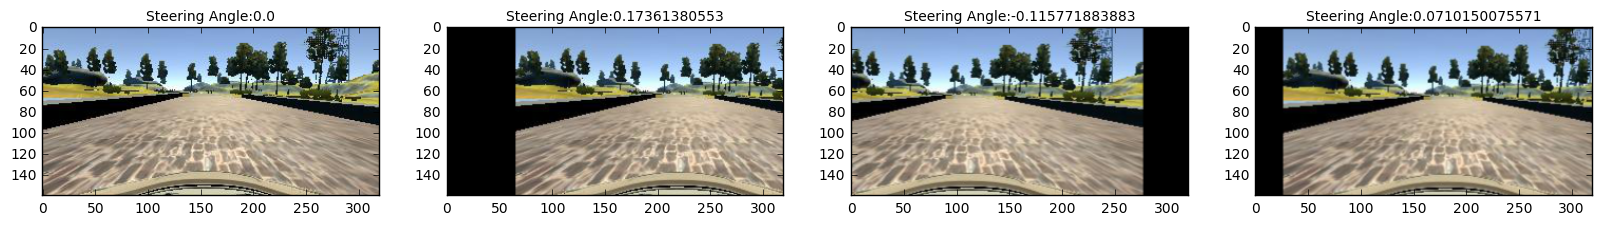

In [10]:
x_translation_range, y_translation_range, angle_translation_range = 150,10,0.2


f, (ax1, ax2,ax3,ax4 ) = plt.subplots(1, 4, figsize=(20,10))
ax1.imshow(image)
ax1.set_title("Steering Angle:"+str(angle), fontsize=10)

new_image,new_angle = image_translation(image, angle, x_translation_range, y_translation_range, angle_translation_range)
ax2.imshow(new_image)
ax2.set_title("Steering Angle:"+str(new_angle), fontsize=10)

new_image,new_angle = image_translation(image, angle, x_translation_range, y_translation_range, angle_translation_range)
ax3.imshow(new_image)
ax3.set_title("Steering Angle:"+str(new_angle), fontsize=10)

new_image,new_angle = image_translation(image, angle, x_translation_range, y_translation_range, angle_translation_range)
ax4.imshow(new_image)
ax4.set_title("Steering Angle:"+str(new_angle), fontsize=10)

## Image Cropping and Resizing 

Top of the image is cropped remove extra information like trees and sky. Also, the image is rescaled to 64 x 64 size. 

In [11]:
def image_preprocess(image,rows,cols):
    roi = image[60:140, :, :]
    new_image = cv2.resize(roi,(cols,rows),interpolation=cv2.INTER_AREA)
    
    return new_image


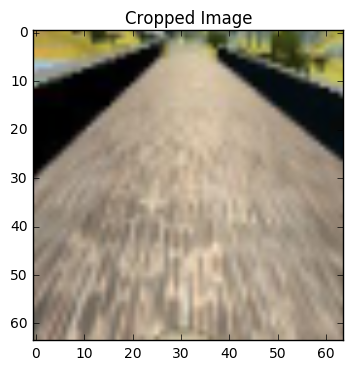

In [12]:
plt.title("Cropped Image")
plt.imshow(image_preprocess(image,64,64))

## Augmenting Training Images

### Steps in augmentation pipeline:

1. Randomly Select the image from 'left','center' and 'right' images and shift the angle accordingly. 0.25 is the number suggested in vivek's post. 
2. Image Rotation
3. Cropping and Resizing Image
4. Randomly flipping the image and angle. It helped in simulating driving in the opposite direction. The data and the track showed a lot of left turns, so in order to balance the left and right turns, images and corresponding steering angles were flipped about the vertical axis. 

In [13]:
def augment_train_image(line_data):
    
    shift_angle = {}
    shift_angle['left'] = 0.25
    shift_angle['center'] = 0.0
    shift_angle['right'] = -0.25
    
    image_selection = ['left','center','right']
    choice = random.choice(image_selection)
    path_file = line_data[choice][0].strip()
    angle = line_data['steering'][0] + shift_angle[choice]
    
    image = plt.imread(path+path_file)
    
    x_translation_range, y_translation_range, angle_translation_range = 150,10,0.2
    image,angle = image_translation(image, angle, x_translation_range, y_translation_range, angle_translation_range)
    
    image = change_brightness(image,brightness_range=0.3)
    image = image_preprocess(image,64,64)
    image = np.array(image)
    ind_flip = np.random.randint(2)
    if ind_flip==0:
        image = cv2.flip(image,1)
        angle = -angle
    
    return image,angle



In [14]:
def augment_predict_image(line_data):
    path_file = line_data['center'][0].strip()
    image = plt.imread(path+path_file)
    image = image_preprocess(image,64,64)
    image = np.array(image)
    return image


## Keras Data Generation

As the data contained angle 0 more then the other angles, it is likely that network will be bias towards driving straight. For that generated more data with slighly bigger angles to remove the bias.   

In [15]:
def train_generator(data,batch_size = 32):
    batch_images = np.zeros((batch_size, 64, 64, 3))
    batch_steering = np.zeros(batch_size)
    while 1:
        for batch in range(batch_size):
            line_data = data.iloc[[np.random.randint(len(data))]].reset_index()
            
            keep_pr = 0
            while keep_pr == 0:
                image,angle = augment_train_image(line_data)
                if abs(angle)<.15:
                    pr_val = np.random.uniform()
                    if pr_val>pr_threshold:
                        keep_pr = 1
                else:
                    keep_pr = 1
            
            batch_images[batch] = image
            batch_steering[batch] = angle
        yield batch_images, batch_steering


In [16]:
def validation_generator(data):
    while 1:
        for line_index in range(len(data)):
            line_data = data.iloc[[line_index]].reset_index()
            image = augment_predict_image(data)
            image = image.reshape(1, image.shape[0], image.shape[1], image.shape[2])
            angle = line_data['steering'][0]
            angle = np.array([[angle]])
            yield image, angle



## Transfer Learning: Nvidia's Model Architecture

* Chose Nvidia's model to investigate how well the already existing models of driving plus the augmentation techniques, generalize to driving in track 1. 
* Model Input: 64 x 64 x 3
* first layer is there to apply normalization on the images
* To avoid overfitting added dropout layers after flattening and fully connected layers, it is the only point where we differ from the nvidia's model
* Used ELU() as ELU() has smoother derivatives at zero. It proved to be better then RELU()

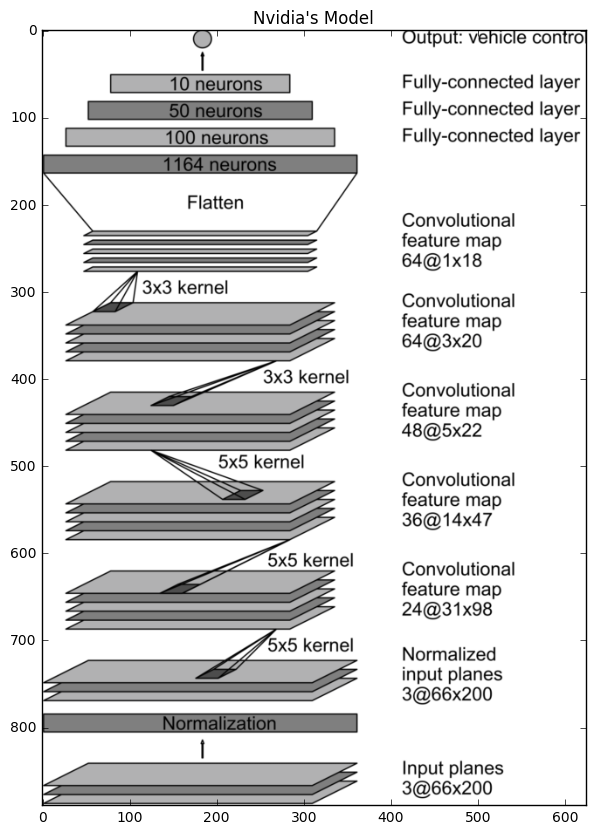

In [17]:
plt.figure(figsize = (40,10))
plt.title("Nvidia's Model")
plt.imshow(plt.imread('cnn-architecture.png'))

In [18]:
def get_model():
    input_shape = (64, 64, 3)
    filter_size = 3
    pool_size = (2,2)
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1,input_shape=input_shape))
    model.add(Convolution2D(24,5,5,border_mode='valid', subsample=(2,2)))
    model.add(ELU())
    
    model.add(Convolution2D(36,5,5,border_mode='valid', subsample=(2,2)))
    model.add(ELU())
    
    model.add(Convolution2D(48,5,5,border_mode='valid', subsample=(2,2)))
    model.add(ELU())
    
    model.add(Convolution2D(64,3,3,border_mode='valid', subsample=(1,1)))
    model.add(ELU())
    
    model.add(Convolution2D(64,3,3,border_mode='valid', subsample=(1,1)))
    model.add(ELU())
    
    model.add(Flatten())
    model.add(Dense(1164))
    model.add(ELU())
    model.add(Dropout(0.5))
    
    model.add(Dense(100))
    model.add(ELU())
    model.add(Dropout(0.5))
    
    model.add(Dense(50))
    model.add(ELU())
    model.add(Dropout(0.5))
    
    model.add(Dense(10))
    model.add(ELU())
    model.add(Dropout(0.5))
    
    model.add(Dense(1))
    
    return model
    


In [19]:
def save_model(fileModelJSON,fileWeights):
    if Path(fileModelJSON).is_file():
        os.remove(fileModelJSON)
    json_string = model.to_json()
    with open(fileModelJSON,'w' ) as f:
        f.write(json_string)
    if Path(fileWeights).is_file():
        os.remove(fileWeights)
    model.save_weights(fileWeights)

In [20]:
ind = df['throttle']>.25
df= df[ind].reset_index()


image_c = plt.imread(path+df['center'][0].strip())
rows,cols,channels = image_c.shape

## Model Training

* We chose the batch_size of 256 as it requires less memory, the network train comparatively faster and it proved to be resulting in appropriate noisy gradients helping in escaping the local minima
* Epochs = 30
* New samples generated for each epoch = Batch_size * 79
* We dropped all the images with small angles, but in later epochs we gradually decreased the probability of dropping images with small angles. 
* Only use validation set to verify the model performance, true validation is to validate the model on track 1, that is the reason we do not stop training because o acheiving a certain validation loss
* Model at each iteration is saved including the best model, similar to checkpoining approach 
* More then one model was found to be good enough to drive on the first track
* Best model is submitted and can be tested by running on track 1

In [ ]:
pr_threshold = 1
batch_size = 256
best_model = 0
val_best = 1000
iterations = 30

model = get_model()
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer=adam,loss='mse')

valid_gen = validation_generator(df)

for iteration in range(iterations):

    train_gen = train_generator(df,batch_size)
    history = model.fit_generator(train_gen,
            samples_per_epoch=256*79, nb_epoch=1,validation_data=valid_gen,
                        nb_val_samples=len(df))
    
    save_model('model_' + str(iteration) + '.json','model_' + str(iteration) + '.h5')
    
    val_loss = history.history['val_loss'][0]
    if val_loss < val_best:
        best_model = iteration 
        val_best = val_loss
        save_model('best_model.json','best_model.h5')
    
    
    pr_threshold = 1/(iteration+1)

print('Best model found at iteration # ' + str(best_model))
print('Best Validation score : ' + str(np.round(val_best,4)))

